In [94]:
#Importing Dependencies
import pandas as pd
import re      #For cleaning obtained tweets 
import joblib  #For saving pipeline
import time

from sklearn.feature_extraction.text import TfidfVectorizer  #For extracting features from data
from sklearn.model_selection import train_test_split         #For splitting dataset
from sklearn.feature_selection import SelectKBest, chi2      #For selecting correct number of features to consider
from sklearn.utils import resample                           #For balancing dataset
from sklearn.naive_bayes import MultinomialNB                #Naive Bayes Classifier module
from sklearn.metrics import accuracy_score, precision_score  #Metrics for assessing the trained model
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import confusion_matrix

from imblearn.pipeline import Pipeline  #To create a pipeline
import nltk                             #Used for data preprocessing
from nltk.probability import FreqDist   #For data exploration
import seaborn as sns                   #To plot metrics
import matplotlib.pyplot as plt
from texttable import Texttable

In [95]:
#Load data
data = pd.read_csv('Twitter_Data.csv', usecols=['text','sentiment'], encoding='utf-8', encoding_errors='ignore', on_bad_lines='skip')

#Drop null values if present
data.dropna()

#Conversion of data to unicode type
data['text']=data['text'].values.astype('U')
data['sentiment']=data['sentiment'].values.astype('U')

#Display first 10 elements of the dataset
data.head(10)

,text,sentiment
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive
5,kiya tho refresh maarkefir comment karo,Neutral
6,surat women perform yagna seeks divine grace f...,Neutral
7,this comes from cabinet which has scholars lik...,Neutral
8,with upcoming election india saga going import...,Positive
9,gandhi was gay does modi,Positive


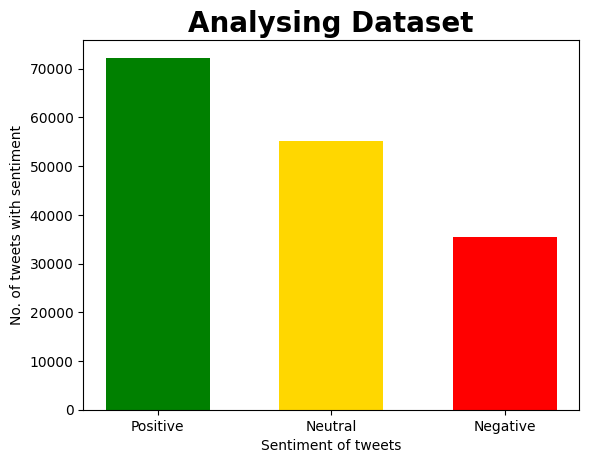

In [96]:
#Separate the tweets based on sentiments
pos_tweets = data[data['sentiment'] == 'Positive']
neu_tweets = data[data['sentiment'] == 'Neutral']
neg_tweets = data[data['sentiment'] == 'Negative']

#Check if the data is balanced or not
def count(tweet_class1,tweet_class2,tweet_class3):   
    pos_count = len(tweet_class1)
    neu_count = len(tweet_class2)
    neg_count = len(tweet_class3)
    
    labels = ['Positive', 'Neutral', 'Negative']
    sizes = [pos_count, neu_count, neg_count]
    colors = ['green', 'gold', 'red']

    #Plot a bar graph showing the number of tweets based on sentiments
    plt.bar(x=labels, height=sizes, width=0.6, color=colors)
    plt.xlabel("Sentiment of tweets")
    plt.ylabel("No. of tweets with sentiment")
    plt.title('Analysing Dataset', fontdict={'fontsize':'20','fontweight':'bold'})
    plt.show()

count(pos_tweets,neu_tweets,neg_tweets)

In [97]:
#Function to oversample classes having lower frequency to match the size of the majority class
def oversample(minority_class, majority_class):
    oversampled_class = resample(minority_class,
                                replace=True,                   #Sample with replacement
                                n_samples=len(majority_class))  #Match the size of the majority class 
    return oversampled_class

#Oversample the neutral and negative tweets to match the number of positive tweets
neu_oversampled = oversample(neu_tweets,pos_tweets)
neg_oversampled = oversample(neg_tweets,pos_tweets)

#Combine all the classes of tweets
bal_data = pd.concat([pos_tweets,neu_oversampled,neg_oversampled])
bal_data = bal_data.sample(frac=1)  #Shuffling the dataset

#Display first 10 elements of the balanced dataset
bal_data.head(10)

,text,sentiment
107879,you not awake then repent india has only solut...,Positive
157110,modi and great chore,Positive
46286,how the dare\ncongratulations and thank you etc,Neutral
47984,india stands tall space power narendra modi th...,Neutral
57939,waiting see indian voters shooting down modi s...,Negative
76509,former cecs say modi’ mission shakti speech co...,Neutral
83780,please tell modi first fix the ground and prov...,Positive
134612,berozgari hits india hard mrmodi get ready ste...,Negative
126412,dont believe modi all now were all disgusted w...,Negative
10293,“joshi sources say now mulling his next move u...,Positive


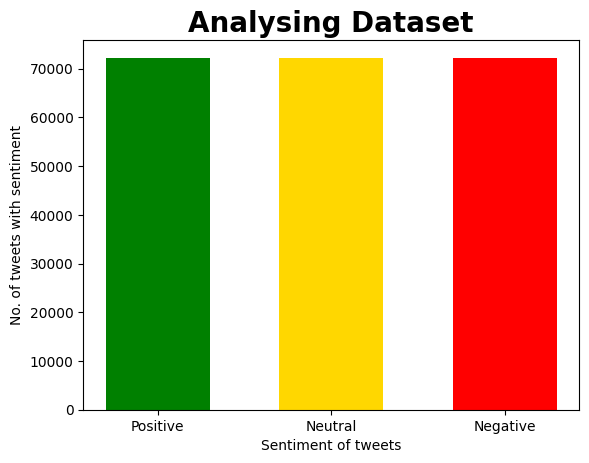

In [98]:
count(pos_tweets,neu_oversampled,neg_oversampled)

In [99]:
#Function to clean the tweets
def remove_tags(string):
    result = re.sub('','',string)                 #Remove HTML tags
    result = re.sub('https://.*','',result)       #Remove URLs
    result = re.sub(r'[^a-zA-Z0-9]', ' ', result) #Remone non-alpha numeric characters
    result = result.lower()                       #Ronvert to lower case
    return result

#Cleaning balanced dataset
bal_data['text']=bal_data['text'].apply(lambda cw : remove_tags(cw))
#Display first 10 elements of the cleaned dataset
bal_data.head(10)

,text,sentiment
107879,you not awake then repent india has only solut...,Positive
157110,modi and great chore,Positive
46286,how the dare congratulations and thank you etc,Neutral
47984,india stands tall space power narendra modi th...,Neutral
57939,waiting see indian voters shooting down modi s...,Negative
76509,former cecs say modi mission shakti speech co...,Neutral
83780,please tell modi first fix the ground and prov...,Positive
134612,berozgari hits india hard mrmodi get ready ste...,Negative
126412,dont believe modi all now were all disgusted w...,Negative
10293,joshi sources say now mulling his next move u...,Positive


In [100]:
#Getting the list of English stopwords from the nltk library
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 
#Removing the stopwords from the tweets in the balanced dataset
bal_data['text'] = bal_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

#Function to perform lemmatization on a text
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st

#Lemmatizing tweets in balanced dataset
bal_data['text'] = bal_data.text.apply(lemmatize_text)
#Print first 10 elements of the pre-processed dataset
bal_data.head(10)

,text,sentiment
107879,awake repent india solution modi closed eye re...,Positive
157110,modi great chore,Positive
46286,dare congratulation thank etc,Neutral
47984,india stand tall space power narendra modi tha...,Neutral
57939,waiting see indian voter shooting modi satelli...,Negative
76509,former cecs say modi mission shakti speech cou...,Neutral
83780,please tell modi first fix ground provide latr...,Positive
134612,berozgari hit india hard mrmodi get ready step...,Negative
126412,dont believe modi disgusted congress upa ally ...,Negative
10293,joshi source say mulling next move unlike adva...,Positive


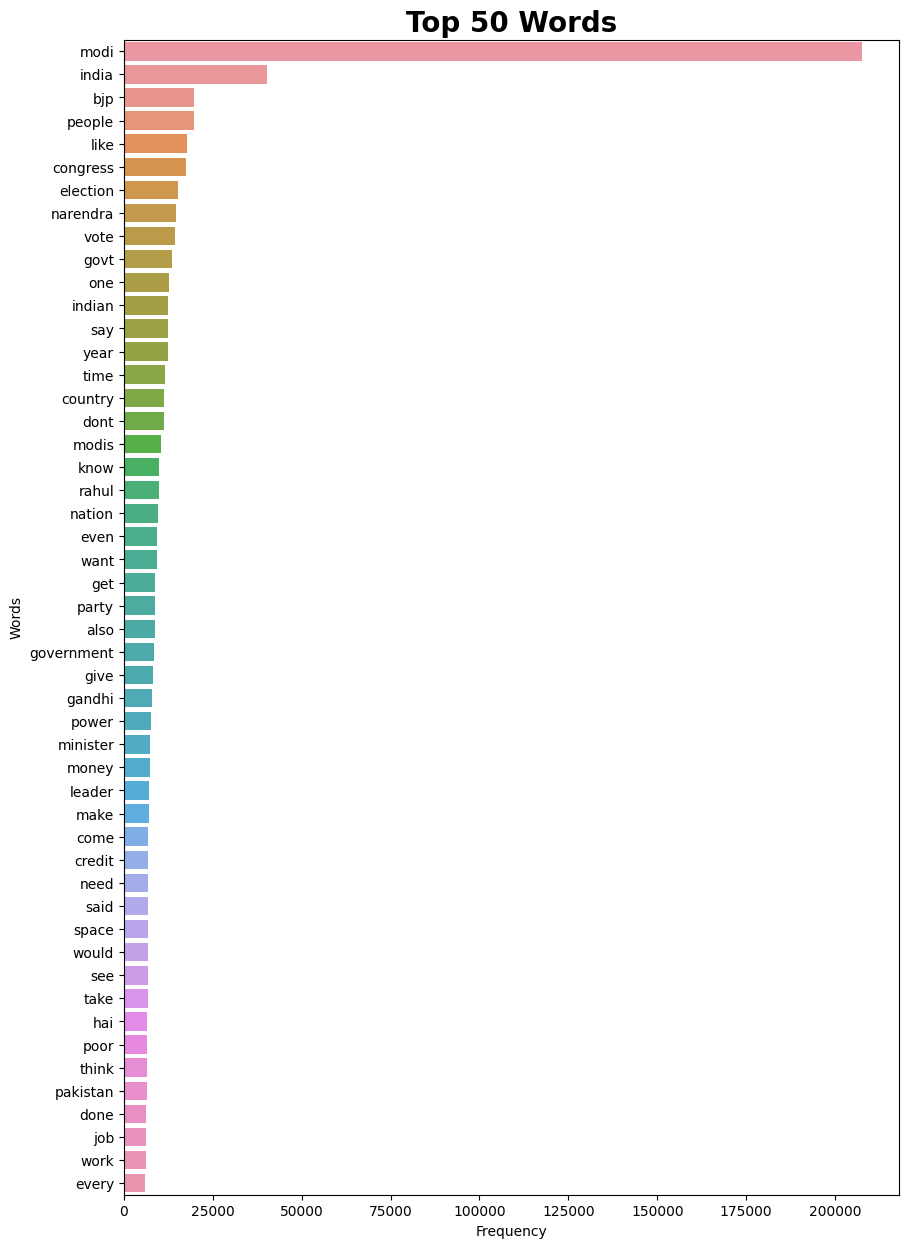

In [101]:
#Function to return topmost 50 words in a text
def fdistwords(text,title):
    #Tokenize the text into words
    words = ' '.join(text)
    words = nltk.tokenize.word_tokenize(words)
    #Calculate the frequency distribution of words
    fdist = FreqDist(words)
    top_words = fdist.most_common(50)
    #Create a bar chart of the top 50 words
    plt.figure(figsize=(10,15))
    sns.barplot(y=[word[0] for word in top_words], x=[word[1] for word in top_words])
    plt.title(title, fontdict={'fontsize':'20','fontweight':'bold'})
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

fdistwords(bal_data['text'], 'Top 50 Words')

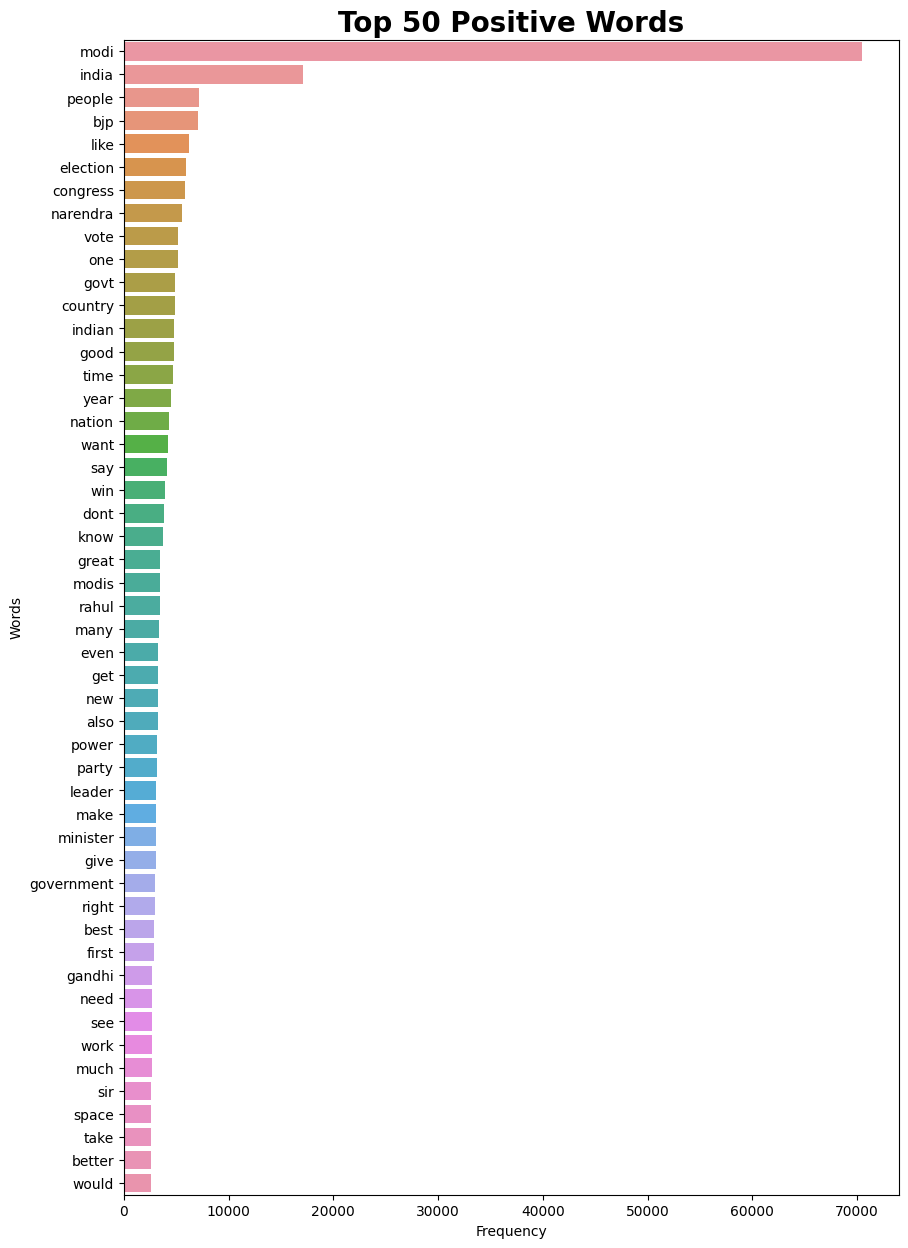

In [102]:
#Create a bar chart of the top 50 positive words
fdistwords(bal_data[bal_data['sentiment'] == 'Positive']['text'], 'Top 50 Positive Words')

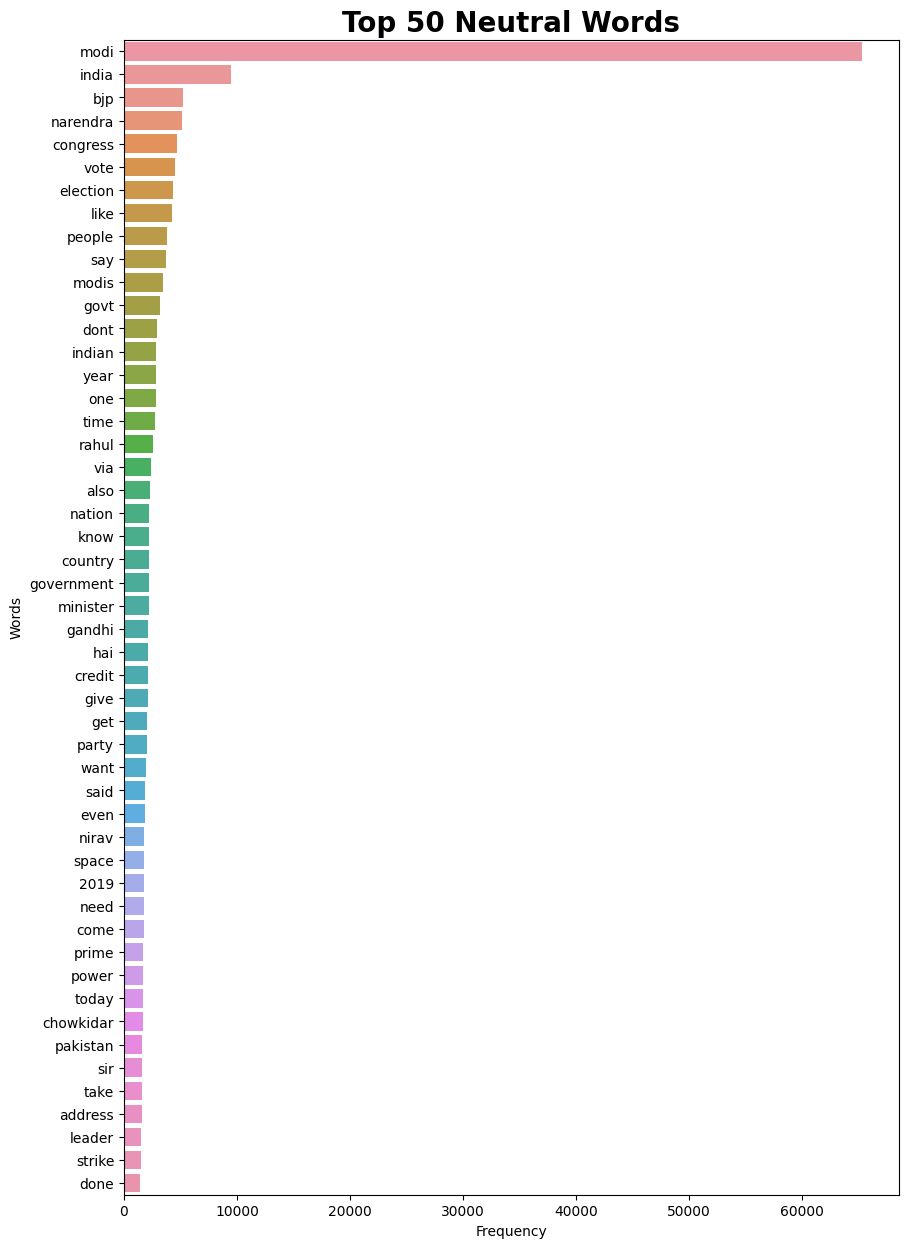

In [103]:
#Create a bar chart of the top 50 neutral words
fdistwords(bal_data[bal_data['sentiment'] == 'Neutral']['text'], 'Top 50 Neutral Words')

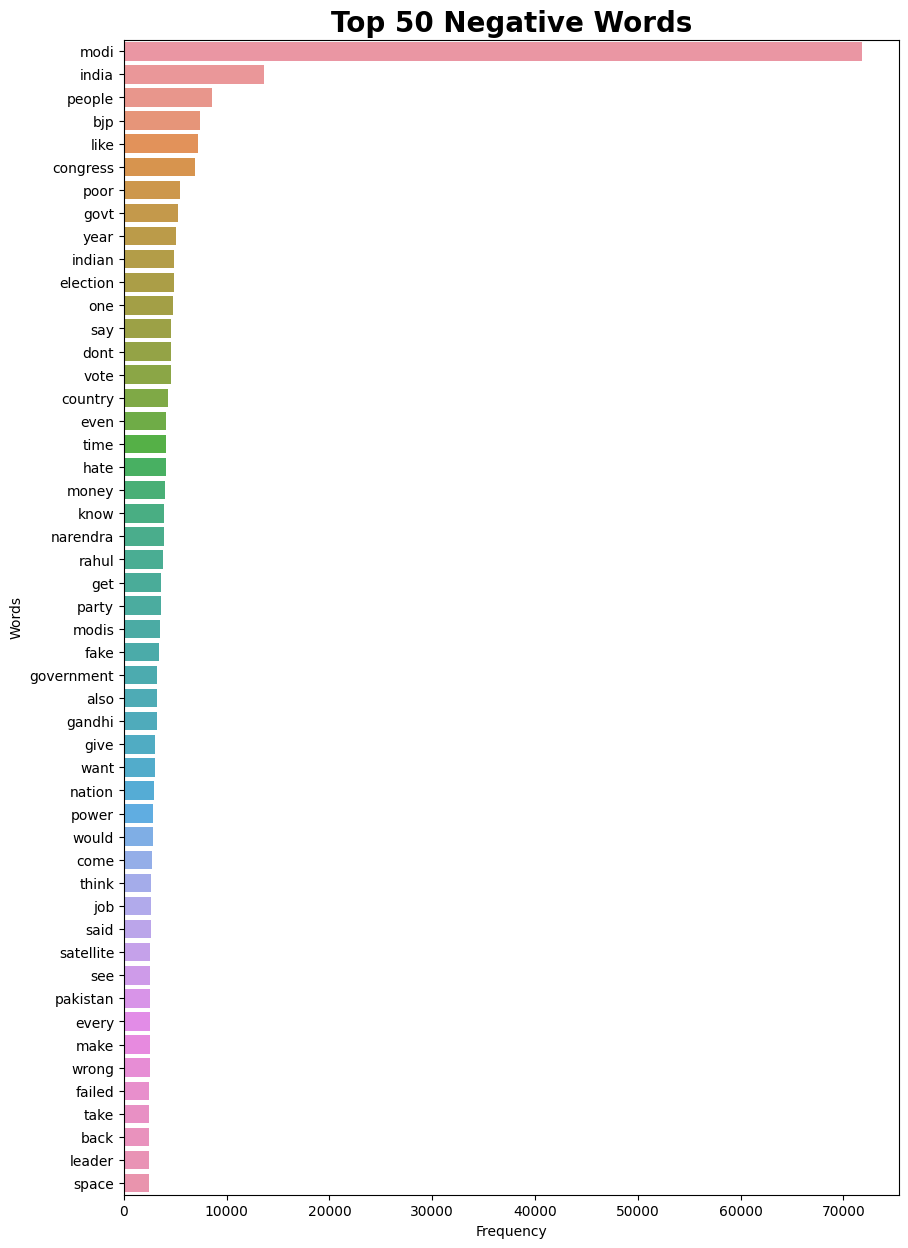

In [104]:
#Create a bar chart of the top 50 negative words
fdistwords(bal_data[bal_data['sentiment'] == 'Negative']['text'], 'Top 50 Negative Words')

In [105]:
#Create a pipeline with three steps:
    #1. TfidfVectorizer: Convert text into numerical feature vectors using TF-IDF representation.
    #2. SelectKBest: Select the top k features based on chi-squared test.
    #3. MultinomialNB: Train a Multinomial Naive Bayes classifier with the specified alpha value.
model = Pipeline([('vectorizer', TfidfVectorizer()),
                     ('selector', SelectKBest(chi2)),
                     ('classifier', MultinomialNB())])

In [106]:
#List of k values to be checked
selector_k = [600,800,1000,1200,1400,1600,1800,2000,2200,'all']  #Selector values to be checked
acc_k = []

table = Texttable()
table.add_row(['K Value', 'Accuracy Value'])

#Split the dataset into training and testing sets
train, test = train_test_split(bal_data, test_size=0.2)

#Loop through each k value and calculate the performance score of the model
for i in range(len(selector_k)):
    model = Pipeline([('vectorizer', TfidfVectorizer()),
                    ('selector', SelectKBest(chi2, k = selector_k[i])),
                    ('classifier', MultinomialNB())])
    #Train the model on the training data
    model.fit(train['text'], train['sentiment'])
    #Make predictions on the test data
    test['predicted_sentiment'] = model.predict(test['text'])
    #Calculate accuracy of the predictions
    accuracy = accuracy_score(test['sentiment'], test['predicted_sentiment'])
    acc_k.append(accuracy)
    table.add_row([selector_k[i], acc_k[i]])

print(table.draw())

+---------+----------------+
| K Value | Accuracy Value |
+---------+----------------+
| 600     | 0.827          |
+---------+----------------+
| 800     | 0.829          |
+---------+----------------+
| 1000    | 0.822          |
+---------+----------------+
| 1200    | 0.819          |
+---------+----------------+
| 1400    | 0.816          |
+---------+----------------+
| 1600    | 0.814          |
+---------+----------------+
| 1800    | 0.811          |
+---------+----------------+
| 2000    | 0.809          |
+---------+----------------+
| 2200    | 0.806          |
+---------+----------------+
| all     | 0.773          |
+---------+----------------+


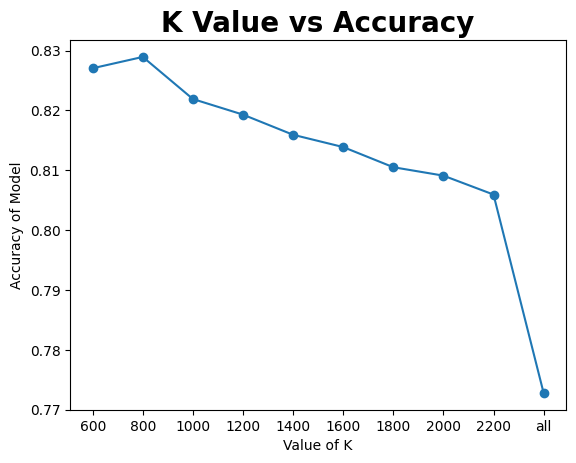

Best value of k: 800


In [107]:
#Create a chart for the alpha values and their respective accuracies
plt.plot(selector_k, acc_k, marker='o')
plt.xlabel("Value of K")
plt.ylabel("Accuracy of Model")
plt.title("K Value vs Accuracy", fontdict={'fontsize':'20','fontweight':'bold'})
plt.show()

#Find the index of the maximum accuracy value
i = acc_k.index(max(acc_k))
#Find the best k value using the index of the maximum accuracy value
best_k = selector_k[i]
print("Best value of k:", best_k)

In [108]:
#List of alpha values to be checked
alpha_value = [1,2,3,4,5,6,7,8,9,10]
acc_alpha = []

table = Texttable()
table.add_row(['Alpha Value', 'Accuracy Value'])

#Split the dataset into training and testing sets
train, test = train_test_split(bal_data, test_size=0.2)

#Loop through each alpha value and calculate the performance score of the model
for i in range(len(alpha_value)):
    model = Pipeline([('vectorizer', TfidfVectorizer()),
                    ('selector', SelectKBest(chi2, k=best_k)),
                    ('classifier', MultinomialNB(alpha=alpha_value[i]))])
    #Train the model on the training data
    model.fit(train['text'], train['sentiment'])
    #Make predictions on the test data
    test['predicted_sentiment'] = model.predict(test['text'])
    #Calculate accuracy of the predictions
    accuracy = accuracy_score(test['sentiment'], test['predicted_sentiment'])
    acc_alpha.append(accuracy)
    table.add_row([alpha_value[i], acc_alpha[i]])

print(table.draw())

+-------------+----------------+
| Alpha Value | Accuracy Value |
+-------------+----------------+
| 1           | 0.827          |
+-------------+----------------+
| 2           | 0.824          |
+-------------+----------------+
| 3           | 0.821          |
+-------------+----------------+
| 4           | 0.819          |
+-------------+----------------+
| 5           | 0.817          |
+-------------+----------------+
| 6           | 0.815          |
+-------------+----------------+
| 7           | 0.811          |
+-------------+----------------+
| 8           | 0.809          |
+-------------+----------------+
| 9           | 0.807          |
+-------------+----------------+
| 10          | 0.805          |
+-------------+----------------+


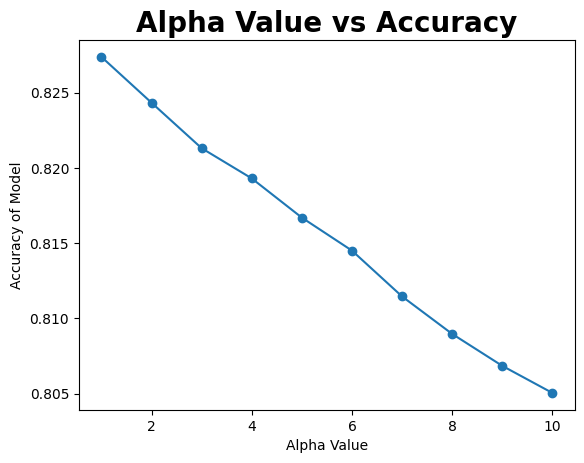

Best value of alpha: 1


In [109]:
#Create a chart for the alpha values and their respective accuracies
plt.plot(alpha_value, acc_alpha, marker='o')
plt.xlabel("Alpha Value")
plt.ylabel("Accuracy of Model")
plt.title("Alpha Value vs Accuracy", fontdict={'fontsize':'20','fontweight':'bold'})
plt.show()

#Find the index of the maximum accuracy value
i = acc_alpha.index(max(acc_alpha))
#Find the best alpha value using the index of the maximum accuracy value
best_alpha = alpha_value[i]
print("Best value of alpha:", best_alpha)

In [110]:
#Redefining the final pipeline with correct hyperparameter values
model = Pipeline([('vectorizer', TfidfVectorizer()),
                ('selector', SelectKBest(chi2, k=best_k)),
                ('classifier', MultinomialNB(alpha=best_alpha))])

In [111]:
bal_data = bal_data.sample(frac=1)

In [112]:
accuracy = []
for i in range(43):
    train, test = train_test_split(bal_data, test_size=0.3, random_state=i)
    model.fit(train['text'],train['sentiment'])
    test['predicted_sentiment'] = model.predict(test['text'])
    accuracy.append(accuracy_score(test['sentiment'], test['predicted_sentiment']))

In [113]:
print(accuracy.index(max(accuracy)))

22


ITERATION NUMBER:  1

DATA: 0 ------------------------>  1000 

ACCURACY: 0.585 

+-----------+----------+---------+----------+
| Sentiment | Positive | Neutral | Negative |
+===========+==========+=========+==========+
| Precision | 0.553    | 0.544   | 0.672    |
+-----------+----------+---------+----------+
| Recall    | 0.671    | 0.544   | 0.534    |
+-----------+----------+---------+----------+
| F1 score  | 0.606    | 0.544   | 0.595    |
+-----------+----------+---------+----------+

CONFUSION MATRIX:

0--->Positive	1--->Neutral	2--->Negative



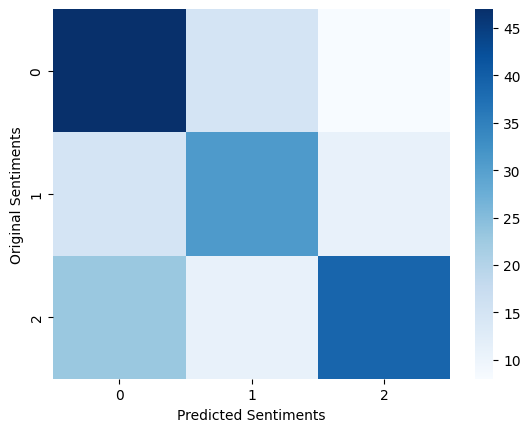

ITERATION NUMBER:  2

DATA: 0 ------------------------>  2000 

ACCURACY: 0.610 

+-----------+----------+---------+----------+
| Sentiment | Positive | Neutral | Negative |
+===========+==========+=========+==========+
| Precision | 0.552    | 0.593   | 0.699    |
+-----------+----------+---------+----------+
| Recall    | 0.725    | 0.411   | 0.674    |
+-----------+----------+---------+----------+
| F1 score  | 0.627    | 0.486   | 0.686    |
+-----------+----------+---------+----------+

CONFUSION MATRIX:

0--->Positive	1--->Neutral	2--->Negative



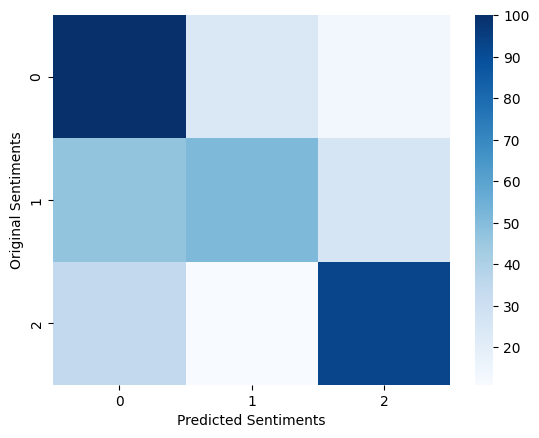

ITERATION NUMBER:  3

DATA: 0 ------------------------>  4000 

ACCURACY: 0.660 

+-----------+----------+---------+----------+
| Sentiment | Positive | Neutral | Negative |
+===========+==========+=========+==========+
| Precision | 0.611    | 0.657   | 0.722    |
+-----------+----------+---------+----------+
| Recall    | 0.747    | 0.552   | 0.674    |
+-----------+----------+---------+----------+
| F1 score  | 0.672    | 0.600   | 0.697    |
+-----------+----------+---------+----------+

CONFUSION MATRIX:

0--->Positive	1--->Neutral	2--->Negative



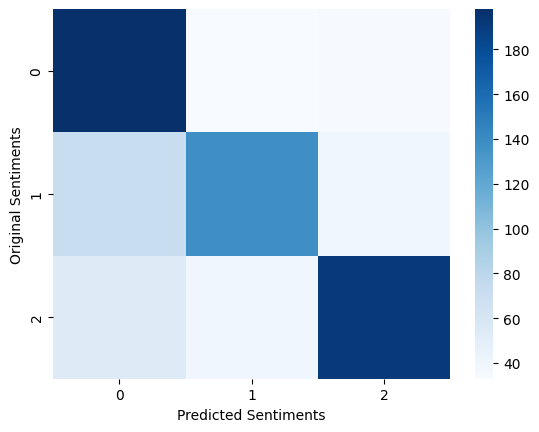

ITERATION NUMBER:  4

DATA: 0 ------------------------>  8000 

ACCURACY: 0.703 

+-----------+----------+---------+----------+
| Sentiment | Positive | Neutral | Negative |
+===========+==========+=========+==========+
| Precision | 0.749    | 0.745   | 0.635    |
+-----------+----------+---------+----------+
| Recall    | 0.722    | 0.628   | 0.760    |
+-----------+----------+---------+----------+
| F1 score  | 0.735    | 0.682   | 0.692    |
+-----------+----------+---------+----------+

CONFUSION MATRIX:

0--->Positive	1--->Neutral	2--->Negative



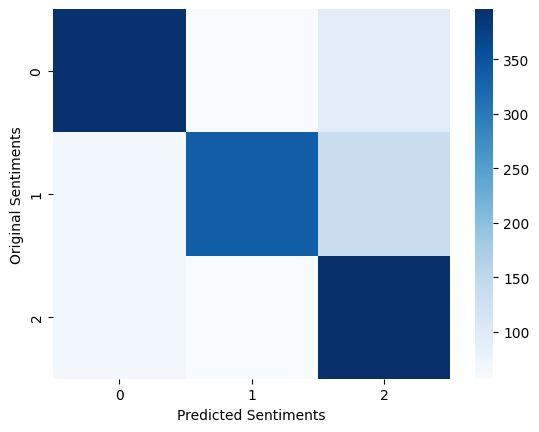

ITERATION NUMBER:  5

DATA: 0 ------------------------>  16000 

ACCURACY: 0.735 

+-----------+----------+---------+----------+
| Sentiment | Positive | Neutral | Negative |
+===========+==========+=========+==========+
| Precision | 0.787    | 0.778   | 0.662    |
+-----------+----------+---------+----------+
| Recall    | 0.730    | 0.665   | 0.813    |
+-----------+----------+---------+----------+
| F1 score  | 0.757    | 0.717   | 0.730    |
+-----------+----------+---------+----------+

CONFUSION MATRIX:

0--->Positive	1--->Neutral	2--->Negative



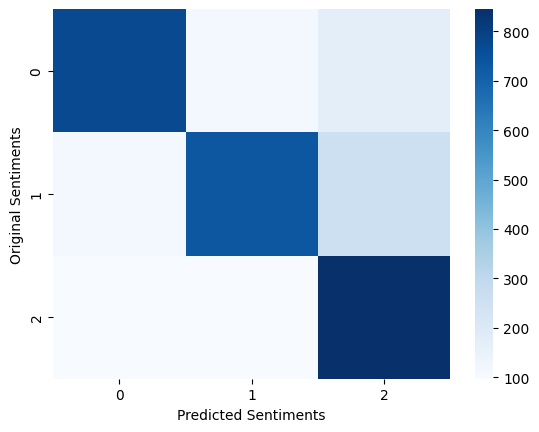

ITERATION NUMBER:  6

DATA: 0 ------------------------>  32000 

ACCURACY: 0.781 

+-----------+----------+---------+----------+
| Sentiment | Positive | Neutral | Negative |
+===========+==========+=========+==========+
| Precision | 0.851    | 0.805   | 0.705    |
+-----------+----------+---------+----------+
| Recall    | 0.743    | 0.775   | 0.826    |
+-----------+----------+---------+----------+
| F1 score  | 0.793    | 0.790   | 0.761    |
+-----------+----------+---------+----------+

CONFUSION MATRIX:

0--->Positive	1--->Neutral	2--->Negative



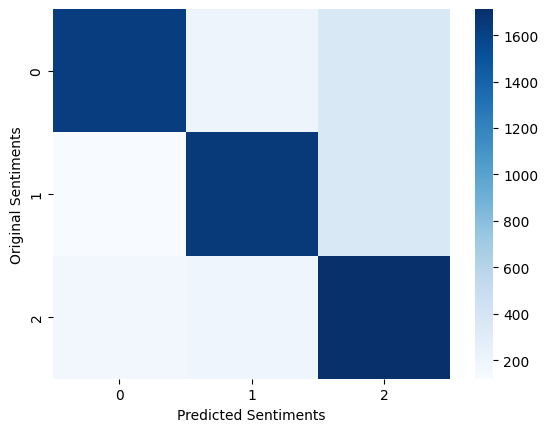

ITERATION NUMBER:  7

DATA: 0 ------------------------>  64000 

ACCURACY: 0.804 

+-----------+----------+---------+----------+
| Sentiment | Positive | Neutral | Negative |
+===========+==========+=========+==========+
| Precision | 0.883    | 0.810   | 0.739    |
+-----------+----------+---------+----------+
| Recall    | 0.762    | 0.812   | 0.839    |
+-----------+----------+---------+----------+
| F1 score  | 0.818    | 0.811   | 0.786    |
+-----------+----------+---------+----------+

CONFUSION MATRIX:

0--->Positive	1--->Neutral	2--->Negative



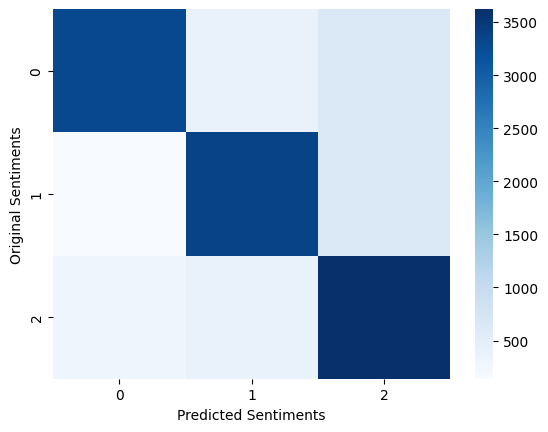

ITERATION NUMBER:  8

DATA: 0 ------------------------>  128000 

ACCURACY: 0.823 

+-----------+----------+---------+----------+
| Sentiment | Positive | Neutral | Negative |
+===========+==========+=========+==========+
| Precision | 0.893    | 0.833   | 0.757    |
+-----------+----------+---------+----------+
| Recall    | 0.783    | 0.841   | 0.844    |
+-----------+----------+---------+----------+
| F1 score  | 0.834    | 0.837   | 0.798    |
+-----------+----------+---------+----------+

CONFUSION MATRIX:

0--->Positive	1--->Neutral	2--->Negative



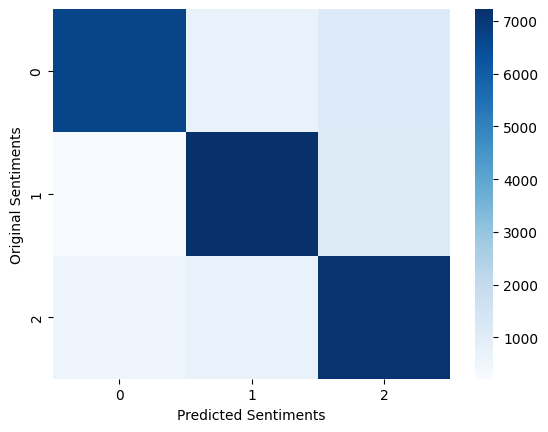

ITERATION NUMBER:  9

DATA: 0 ------------------------>  216750 

ACCURACY: 0.843 

+-----------+----------+---------+----------+
| Sentiment | Positive | Neutral | Negative |
+===========+==========+=========+==========+
| Precision | 0.887    | 0.840   | 0.808    |
+-----------+----------+---------+----------+
| Recall    | 0.785    | 0.902   | 0.840    |
+-----------+----------+---------+----------+
| F1 score  | 0.833    | 0.870   | 0.824    |
+-----------+----------+---------+----------+

CONFUSION MATRIX:

0--->Positive	1--->Neutral	2--->Negative



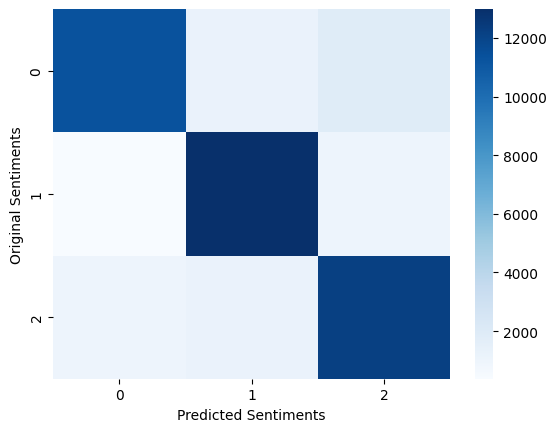

In [120]:
steps=[]
acc=[]
tot_time=[]
train_time=[]
train_data_size=[]
test_time=[]
test_data_size=[]

a=0
i=1000

#Divide the dataset into small sets
while i<len(bal_data['text']):
    steps.append(i)
    i=i*2
    a=a+1
steps.append(len(bal_data['text']))

#Loop through each value and calculate the performance score of the model
for i in range(len(steps)):
    #Get the first i rows of the dataset
    sub=bal_data.head(steps[i])
    #Split the dataset into training and testing sets
    train, test = train_test_split(sub, test_size=0.2, random_state=22)
    #Store the train data size
    train_data_size.append(train.size)
    #Store the test data size
    test_data_size.append(test.size)
    #Train the model on the training data
    model.fit(train['text'],train['sentiment'])
    #Store the time taken to train model
    t=time.time()
    train_time.append(t)
    #Make predictions on the test data
    test['predicted_sentiment'] = model.predict(test['text'])
    #Calculate the total time taken to train and test model
    tott=time.time()
    tot_time.append(tott)
    #Store the time taken to test the model
    test_time.append(tott-t)

    #Calculate accuracy
    accuracy = accuracy_score(test['sentiment'], test['predicted_sentiment'])
    #Calculate precision
    precision = precision_score(test['sentiment'], test['predicted_sentiment'], labels=['Positive', 'Neutral', 'Negative'], average=None)
    #Calculate recall
    recall = recall_score(test['sentiment'], test['predicted_sentiment'], labels=['Positive', 'Neutral', 'Negative'], average=None)
    #Calculate F1 score
    f1 = f1_score(test['sentiment'], test['predicted_sentiment'], labels=['Positive', 'Neutral', 'Negative'], average=None)
    
    #Displaying calculated results
    table = Texttable()
    print("ITERATION NUMBER: ",i+1)
    print("\nDATA: 0 ------------------------> ",steps[i],"\n")
    print("ACCURACY: %0.3f"%accuracy,"\n")
    table.add_rows([['Sentiment','Positive','Neutral','Negative'], ['Precision',precision[0],precision[1],precision[2]],['Recall',recall[0],recall[1],recall[2]],['F1 score',f1[0],f1[1],f1[2]]])
    print(table.draw())
    #Calculate confusion matrix
    cm = confusion_matrix(test['sentiment'], test['predicted_sentiment'], labels=['Positive', 'Neutral', 'Negative'])
    print("\nCONFUSION MATRIX:")
    #print(cm)
    print("\n0--->Positive\t1--->Neutral\t2--->Negative\n")
    sns.heatmap(cm, cmap="Blues")
    #Set plot labels
    plt.xlabel("Predicted Sentiments")
    plt.ylabel("Original Sentiments")
    plt.show()
    acc.append(accuracy)

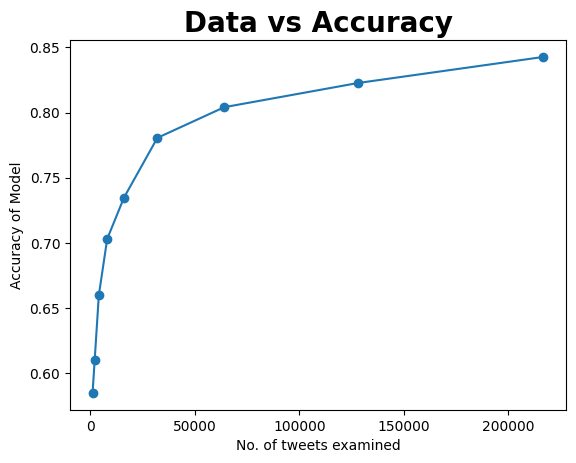

In [121]:
#Create a chart of the accuracy of model and length of dataset it was trained and tested on
plt.plot(steps,acc, marker='o')
plt.xlabel("No. of tweets examined")
plt.ylabel("Accuracy of Model")
plt.title("Data vs Accuracy", fontdict={'fontsize':'20','fontweight':'bold'})
plt.show()

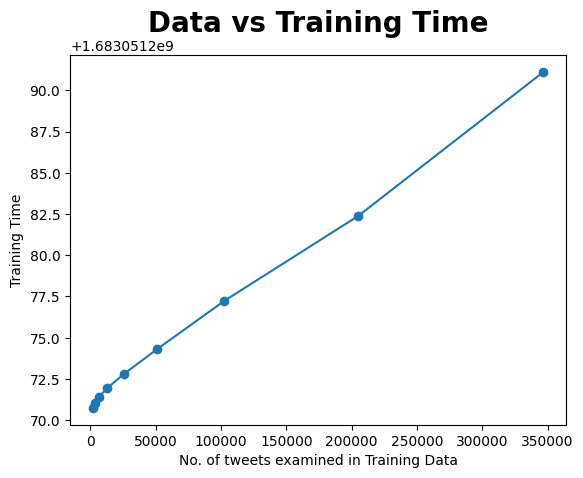

In [122]:
#Create a chart of the time taken by model to train on dataset
plt.plot(train_data_size,train_time, marker='o')
plt.xlabel("No. of tweets examined in Training Data")
plt.ylabel("Training Time")
plt.title("Data vs Training Time", fontdict={'fontsize':'20','fontweight':'bold'})
plt.show()

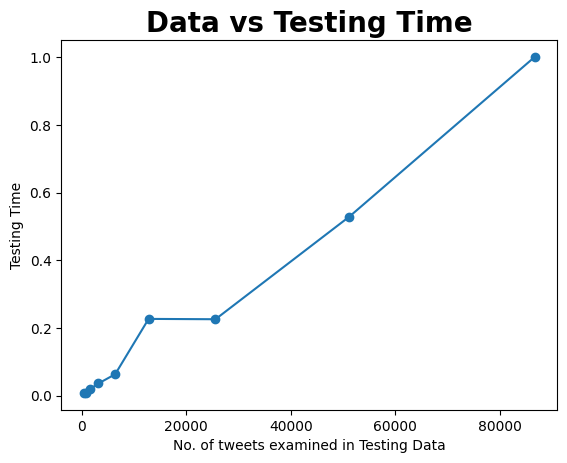

In [123]:
#Create a chart of the time taken by model to test on dataset
plt.plot(test_data_size,test_time, marker='o')
plt.xlabel("No. of tweets examined in Testing Data")
plt.ylabel("Testing Time")
plt.title("Data vs Testing Time", fontdict={'fontsize':'20','fontweight':'bold'})
plt.show()

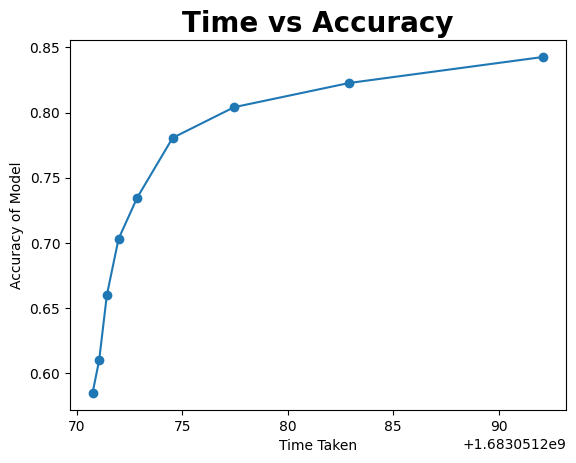

In [124]:
#Create a chart of the accuracy of model and the time taken by it
plt.plot(tot_time,acc, marker='o')
plt.xlabel("Time Taken")
plt.ylabel("Accuracy of Model")
plt.title("Time vs Accuracy", fontdict={'fontsize':'20','fontweight':'bold'})
plt.show()

In [125]:
#Saving the trained pipeline
joblib.dump(model, 'SentimentPredictor.pkl')

['SentimentPredictor.pkl']